# Past-aware game-theoretic centrality in complex contagion dynamics

In [1]:
import networkx as nx
import numpy as np
import math
import osmnx as ox
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.io import mmread
import itertools
from tqdm.notebook import tqdm
import time
import matplotlib as mpl

## Past-aware game-theoretic centrality (PAGTC) computation

### General semivalue PAGTC formula
Given a graph $G=(V,E)$, the semivalue PAGTC associated with the one-round influence group centrality
$$\nu_K(S) = |S|+\Bigl|\bigl\{u\in V\setminus\{S\}: |N(u)\cap S|\ge K\bigr\}\Bigr|,\quad\text{for $S\subseteq V$},$$
where $N(u)$ is the set of neighbors of $u$, can be computed as
$$
\phi^{\beta}_{\nu_K}(u|S_0)=C_\beta
\sum_{s=0}^{n-1}\dfrac{\beta(s)}{\binom{n-1}{s}}
\left[\sum_{v\in N(u)}
\binom{s_v-1}{r_v}\binom{n-1-|S_0|-s_v}{s-|S_0|-r_v}
+\sum_{j=0}^{m}
\binom{s_u}{j}
\binom{n-1-|S_0|-s_u}{s-|S_0|-j}
\right]
$$
where $s_v$ is the number of neighbors of $v$ outside $S_0$, and
$$
r_v=K-1-(\deg(v)-s_v)=K-1-|N(v)\cap S_0|
$$
$$
C_\beta=\left(\sum_{s=|S_0|}^{n-1}\beta(s)\dfrac{\binom{n-1-|S_0|}{s-|S_0|}}{\binom{n-1}{s}}\right)^{\!\!-1}
$$

In [2]:
def beta(n, s): # sum_s beta(n,s) = 1
    return 1/n # Shapley value

def binom(n, k):
    # return 0 if k < 0 else scipy.special.comb(n,k, exact=False)
    return 0 if k < 0 or n < 0 else math.comb(n,k)

# General semivalue PAGTC centrality (slow, for testing)
def pagtc_semivalue(G, K=3, S0=[], nodes=None, beta=beta):

    n = len(G)
    s0 = len(S0)
    s_values = [s for s in range(n) if beta(n, s) != 0]

    c_beta = 0
    for s in s_values:
        c_beta += beta(n,s) * binom(n-1-s0, s-s0) / binom(n-1, s)
    c_beta = 1/c_beta

    if nodes == None:
        nodes = G.nodes
    centrality = {u : 0 for u in nodes}
    for u in nodes:
        if u not in S0:
            for s in s_values:
                b = beta(n, s) / binom(n-1, s)
                for v in G.successors(u):
                    if v not in S0:
                        d = G.in_degree(v)
                        h = len(set(G.predecessors(v)).intersection(set(S0)))
                        centrality[u] += (b * binom(d-h-1, K-h-1) *
                            binom(n-1-d-s0+h, s-K+1-s0+h))
                c = 0
                d = G.in_degree(u)
                h = len(set(G.predecessors(u)).intersection(set(S0)))
                for j in range(K):
                    c += binom(d-h, j-h) * binom(n-1-d-s0+h, s-j-s0+h)

                centrality[u] += b * c
    return {u: c_beta * y for u,y in centrality.items()}

### Fast formula for Shapley PAGTC

When $\beta$ is distributed uniformly, i.e., in the case of Shapley value, we have

$$\phi^{\mathrm{Sh}}_{\nu_K} (u|S_0)=(|S_0|+1)\left[
\underbrace{
    \dfrac{\dfrac{\binom{|S_0|+1+\min\{s_u,r_u\}}{|S_0|+1}}{\binom{|S_0|+s_u}{|S_0|}}}{|S_0|+s_u+1}
}_{c_1(u)}
+\sum_{\substack{v\in N(u)\\ v\notin S_0,\,\deg(v)\ge K}}\underbrace{\,\,\dfrac{\dfrac{\binom{s_v-1}{r_v}}{\binom{|S_0|+s_v}{|S_0|+r_v}}
}{|S_0|+s_v+1}\,\,}_{c_2(v)}\right]$$

In [3]:
def pagtc_shapley(G, K=3, S0=[], nodes=None):
    s0 = len(S0)
    s_set = set(S0)
    if nodes == None:
        nodes = G.nodes
    
    sv, rv, dv = {}, {}, {}
    for v in G.nodes:
        dv[v] = G.in_degree(v)
        h = len(set(G.predecessors(v)).intersection(s_set))
        rv[v] = K-1-h
        sv[v] = dv[v]-h
    
    c1, c2 = {v : 0 for v in G.nodes}, {v : 0 for v in G.nodes}
    for v in G.nodes:
        if v not in s_set:
            l = min(sv[v], rv[v])
            c1[v] = binom(s0+l+1, s0+1) / binom(s0+sv[v], s0) / (s0+sv[v]+1)
            if K <= dv[v]:
                c2[v] = binom(sv[v]-1, rv[v]) / binom(s0+sv[v], s0+rv[v]) / (s0+sv[v]+1)

    centrality = {u : 0 for u in nodes}
    for u in nodes:
        if u not in s_set:
            for v in G.successors(u):
                centrality[u] += c2[v]
            centrality[u] += c1[u]
    return {u: (s0+1)*y for u, y in centrality.items()}

### Fast formula for semivalue PAGTC with $\beta=\delta_s$
When the support of $\beta$ is concentrated at a given $s$, we have
$$
\phi^{\delta_{s}}_{\nu_K}(u|S_0)=\underbrace{\sum_{j=0}^{\min\{s_u,r_u\}}\dfrac{\binom{n-1-s}{s_u-j}\binom{s-|S_0|}{j}}{\binom{n-1-|S_0|}{s_u}}}_{c_1(u)}
+\sum_{\substack{v\in N(u),\,v\notin S_0,\\ \deg(v)\ge K}}\underbrace{\dfrac{\binom{n-1-s}{s_u-r_v}\binom{s-|S_0|}{r_v}\left(1-\frac{r_v}{s_v}\right)}{\binom{n-1-|S_0|}{s_u}}}_{c_2(v)}$$

In [4]:
def pagtc_delta(G, s, K=3, S0=[], nodes=None):
    n = len(G)
    s0 = len(S0)
    s_set = set(S0)

    if nodes == None:
        nodes = G.nodes

    sv, rv, dv = {}, {}, {}
    for v in G.nodes:
        dv[v] = G.in_degree(v)
        h = len(set(G.predecessors(v)).intersection(s_set))
        rv[v] = K-1-h
        sv[v] = dv[v]-h

    c1, c2 = {v : 0 for v in G.nodes}, {v : 0 for v in G.nodes}
    for v in G.nodes:
        if v not in s_set:
            l = min(sv[v], rv[v])
            for j in range(l+1):
                c1[v] += binom(n-1-s, sv[v]-j) / binom(n-1-s0, sv[v]) * binom(s-s0, j)
            if K <= dv[v] and sv[v] > 0:
                c2[v] = binom(n-1-s, sv[v]-rv[v]) / binom(n-1-s0, sv[v]) * binom(s-s0, rv[v])*(1-rv[v]/sv[v])

    centrality = {u : 0 for u in nodes}
    for u in nodes:
        if u not in s_set:
            for v in G.successors(u):
                centrality[u] += c2[v]
            centrality[u] += c1[u]
    return centrality

## K-Complex Contagion (K-CC) dynamics

In [5]:
# One round of K-CC, starting from seeds in 'influenced':
# every node with at least K neighbors in 'influenced' becomes influenced too
def one_round_evolution(G, K, influenced):
    influenced = set(influenced)
    influenced_neighbors = {u: 0 for u in G}
    for v in influenced:
        for u in G.neighbors(v):
            if u not in influenced:
                influenced_neighbors[u] += 1
    next_influenced = [u for u, c in influenced_neighbors.items() if c >= K]
    return list(influenced | set(next_influenced))

# Full K-CC, starting from seeds in 'influenced'
def full_evolution(G, K, influenced):
    A = set(influenced)
    count = {v: 0 for v in G}
    Q = list(influenced)
    while Q:
        u = Q.pop(0)
        for v in G[u]:
            if v not in A:
                count[v] += 1
                if count[v] >= K:
                    A.add(v)
                    Q.append(v)
    return A

# Alternating one K-CC round and external influence of a node,
# according to 'strategy'
def targeted_evolution(G, K, strategy):
    growth = [0]
    influenced = []
    while len(influenced) < len(G):
        u = strategy(G, K, influenced)
        influenced.append(u)
        influenced = one_round_evolution(G, K, influenced)
        growth.append(len(influenced))
    return growth

### Strategies for node selection

Input:
  - graph $G$
  - threshold $K$ for CC
  - set of currently influenced nodes

Output:
  - node $u$ not yet influenced

In [6]:
# Choose non-influenced node with maximum degree
def degree_strategy(G, K, influenced):
    centrality = nx.out_degree_centrality(G)
    for u in influenced:
        centrality.pop(u)
    return max(centrality, key=centrality.get)

# Choose non-influenced node with maximum Shapley PAGTC
def pagtc_shapley_strategy(G, K, influenced):
    centrality = pagtc_shapley(G, K=K, S0=influenced)
    for u in influenced:
        centrality.pop(u)
    return max(centrality, key=centrality.get)

# Choose non-influenced node with maximum semivalue PAGTC
# with beta = delta_s 
def pagtc_delta_strategy(s):
    def semivalue_strategy(G, K, influenced):
        centrality = pagtc_delta(G, s, K=K, S0=influenced)
        for u in influenced:
            centrality.pop(u)
        return max(centrality, key=centrality.get)
    return semivalue_strategy

# Choose non-influenced node with maximum semivalue PAGTC
# with uniform beta concentrated approximately on t < s < t + ratio * (n-1 - t)
# where t is the number of currently influenced nodes
def pagtc_beta_strategy(ratio):
    def semivalue_strategy(G, K, influenced):
        t = len(influenced)
        centrality = pagtc_semivalue(G, K=K, S0=influenced, beta=lambda n, s: 0 if s < t or s >= t+max(1, int(ratio * (n-1-t))) else 1)
        for u in influenced:
            centrality.pop(u)
        return max(centrality, key=centrality.get)
    return semivalue_strategy

# Choose non-influenced node which maximizes the local increment
# of one-round influence (i.e., number of influenced nodes after one round)
def greedy_strategy(G, K, influenced):
    best = len(influenced)
    for u in [w for w in G if w not in influenced]:
        try_influenced = influenced.copy()
        try_influenced.append(u)
        try_influenced = one_round_evolution(G, K, try_influenced)
        if len(try_influenced) > best:
            best = len(try_influenced)
            best_u = u
    return best_u

# Choose non-influenced node which maximizes the local increment
# of full influence (i.e., number of influenced nodes after full K-CC)
def full_greedy_strategy(G, K, influenced):
    best = len(influenced)
    for u in [w for w in G if w not in influenced]:
        try_influenced = influenced.copy()
        try_influenced.append(u)
        try_influenced = full_evolution(G, K, try_influenced)
        if len(try_influenced) > best:
            best = len(try_influenced)
            best_u = u
    return best_u

### Testing framework

In [7]:
# Test different strategies for one-round influence in K-CC problem, with budget r
#   - g_input can be a graph or a list of graphs (the average performance will be used in that case)
#   - if opt==True also computes optimal solution
def test_one_round_evolution(g_input, K, r, strategies, opt=False, draw=True, **kwargs):
    if isinstance(g_input, (list, tuple)):
        g_list = g_input
        draw = False
    else:
        g_list = [g_input]
    score = {}
    for G in g_list:
        solutions = {label: construct_solution(G, K, r, strategy) for label, strategy in strategies.items()}
        if opt:
            solutions['opt'] = find_opt_group(G, K, r)
        if draw:
            _, ax = plt.subplots(1, len(solutions), figsize=(8,8/len(solutions)))
        for i, label in enumerate(solutions):
            influenced = solutions[label]
            new_influenced = one_round_evolution(G, K, influenced)
            if draw:
                colors = ['r' if u in influenced else ('b' if u in new_influenced else 'k') for u in G]
                nx.draw(G.to_undirected(), ax=ax[i], node_size=30, node_color=colors, **kwargs)
                ax[i].set_title(label)
            if label not in score:
                score[label] = 0
            score[label] += len(new_influenced)/len(G) / len(g_list)
    return score

# Test different strategies for full influence in K-CC problem, with budget r
#   - g_input can be a graph or a list of graphs (the average performance will be used in that case)
#   - if opt==True also computes optimal solution
def test_full_evolution(g_input, K, r, strategies, opt=False, draw=True, **kwargs):
    if isinstance(g_input, (list, tuple)):
        g_list = g_input
        draw = False
    else:
        g_list = [g_input]
    score = {}
    for G in g_list:
        solutions = {label: construct_solution(G, K, r, strategy) for label, strategy in strategies.items()}
        if opt:
            solutions['opt*'] = find_full_opt_group(G, K, r)
        if draw:
            _, ax = plt.subplots(1, len(solutions), figsize=(8,8/len(solutions)))
        for i, label in enumerate(solutions):
            influenced = solutions[label]
            new_influenced = full_evolution(G, K, influenced)
            if draw:
                colors = ['r' if u in influenced else ('b' if u in new_influenced else 'k') for u in G]
                nx.draw(G.to_undirected(), ax=ax[i], node_size=30, node_color=colors, **kwargs)
                ax[i].set_title(label)
            if label not in score:
                score[label] = 0
            score[label] += len(new_influenced)/len(G) / len(g_list)
    return score

# Test different strategies for targeted K-CC problem;
# g_input can be a graph or a list of graphs (the average performance will be used in that case)
def test_targeted_evolution(g_input, K, strategies, draw=True, **kwargs):
    if isinstance(g_input, (list, tuple)):
        g_list = g_input
        draw = False
    else:
        g_list = [g_input]
    score = {}
    for G in g_list:
        growths = {label: targeted_evolution(G, K, strategy) for label, strategy in strategies.items()}        
        if draw:
            _, ax = plt.subplots(figsize=(4,3))
        for label in strategies:
            growth = growths[label]
            if draw:
                ax.plot(growth, label=label, **kwargs)
            if label not in score:
                score[label] = 0
            score[label] += (len(growth)-1)/len(G) / len(g_list)
        if draw:
            ax.legend()
    return score

# Construct solution according to strategy
def construct_solution(G, K, r, strategy):
    growth = [0]
    influenced = []
    while len(influenced) < r:
        u = strategy(G, K, influenced)
        influenced.append(u)
        growth.append(len(influenced))
    return influenced

# Find optimal solution for one-round influence problem
def find_opt_group(G, K, r):
    nodes = list(G.nodes)
    neighbors = {u: set(G.neighbors(u)) for u in nodes}
    best = 0
    best_subset = None
    all_combos = itertools.combinations(nodes, r)
    total = math.comb(len(nodes), r)
    for subset in tqdm(all_combos, total=total, leave=False):
        influenced = set(subset)
        new_influenced = {
            u for u in nodes
            if u not in influenced and len(neighbors[u] & influenced) >= K
        }
        total_influenced = len(influenced | new_influenced)
        if total_influenced > best:
            best = total_influenced
            best_subset = subset

    return best_subset

# Find optimal solution for full influence problem
def find_full_opt_group(G, K, r):
    nodes = list(G.nodes)
    neighbors = {u: set(G.neighbors(u)) for u in nodes}
    best = 0
    best_subset = None
    all_combos = itertools.combinations(nodes, r)
    total = math.comb(len(nodes), r)
    for subset in tqdm(all_combos, total=total, leave=False):
        influenced = set(subset)
        changed = True
        while changed:
            changed = False
            newly = {
                u for u in nodes
                if u not in influenced and len(neighbors[u] & influenced) >= K
            }
            if newly:
                influenced |= newly
                changed = True

        total_influenced = len(influenced)
        if total_influenced > best:
            best = total_influenced
            best_subset = subset
    return best_subset

# Print results of selected keys in score dict,
# highlight the highest value (lowest if reverse==True) 
def print_score(score, keys, reverse=False):
    best = min if reverse else max
    for k in keys:
        if k in score:
            if score[k] == best(score.values()):
                print(f'{k}: {score[k]*100:.1f}*', end='\t')
            else:
                print(f'{k}: {score[k]*100:.1f} ', end='\t')
    print('')

## Experiments

### Importing graphs

In [8]:
small_world = []
for i in range(100):
    G = nx.navigable_small_world_graph(5, dim=2, seed=i)
    G.remove_edges_from(nx.selfloop_edges(G))
    G = G.to_undirected().to_directed()
    small_world.append(G)

flor_families = nx.florentine_families_graph().to_directed()
les_miserables = nx.les_miserables_graph().to_directed()
retweets = nx.from_scipy_sparse_array(mmread("rt-retweet/rt-retweet.mtx")).to_directed()
fb_messages = nx.from_scipy_sparse_array(mmread("ia-fb-messages/ia-fb-messages.mtx")).to_directed()

### Code for Figure 2

  0%|          | 0/480700 [00:00<?, ?it/s]

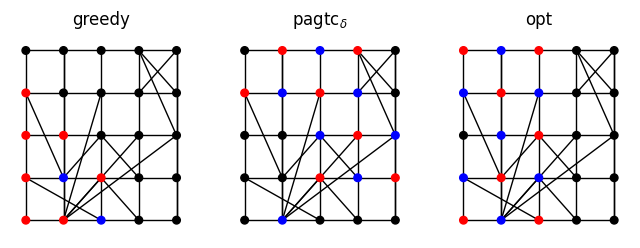

In [9]:
G = nx.navigable_small_world_graph(5, dim=2, seed=21).to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))
G = G.to_directed()
m = 3
T = 7
strategies = {
    'greedy': greedy_strategy,
    r'pagtc$_\delta$': pagtc_delta_strategy(T-1),
}
score = test_one_round_evolution(G, m, T, strategies=strategies, opt=True, draw=True, pos={u:u for u in G})

### Code for Tables 1 and 2

In [10]:
graphs = [
    # (small_world, 'Navigable small-world'),
    # (flor_families, 'Florentine families'),
    (les_miserables, 'Les Misérables'),
    # (retweets, 'Retweets'),
    # (fb_messages, 'FB messages'),
]

for G, graph_name in graphs:
    print(graph_name)
    print('\tone-step')
    for K in [2,3,4]:
        r = 2*K
        strategies = {
            'greedy': greedy_strategy,
            'pagtc_delta': pagtc_delta_strategy(r-1),
        } 
        score = test_one_round_evolution(G, K, r, strategies, opt=False, draw=False)
        print(f'\t\tK={K}\t', end='')
        print_score(score, list(strategies.keys())+['opt'])
    
    print('\tfull')
    for K in [2,3,4]:
        r = 2*K        
        strategies = {
            'greedy*': full_greedy_strategy,
            'pagtc_delta': pagtc_delta_strategy(r-1),
        } 
        score = test_full_evolution(G, K, r, strategies, opt=False, draw=False)
        print(f'\t\tK={K}\t', end='')
        print_score(score, list(strategies.keys())+['opt*'])

    print('\ttargeted')    
    for K in [2,3,4]:
        strategies = {
            'degree': degree_strategy,
            'greedy': greedy_strategy,
            'greedy*': full_greedy_strategy,
            'pagtc_sh': pagtc_shapley_strategy,
        } 
        score = test_targeted_evolution(G, K, strategies, draw=False)
        print(f'\t\tK={K}\t', end='')
        print_score(score, strategies.keys(), reverse=True)


Les Misérables
	one-step
		K=2	greedy: 7.8 	pagtc_delta: 35.1*	
		K=3	greedy: 9.1 	pagtc_delta: 29.9*	
		K=4	greedy: 11.7 	pagtc_delta: 31.2*	
	full
		K=2	greedy*: 80.5*	pagtc_delta: 70.1 	
		K=3	greedy*: 10.4 	pagtc_delta: 45.5*	
		K=4	greedy*: 11.7 	pagtc_delta: 33.8*	
	targeted
		K=2	degree: 29.9 	greedy: 27.3 	greedy*: 24.7*	pagtc_sh: 24.7*	
		K=3	degree: 49.4 	greedy: 45.5 	greedy*: 40.3*	pagtc_sh: 40.3*	
		K=4	degree: 63.6 	greedy: 58.4 	greedy*: 54.5 	pagtc_sh: 49.4*	


### Code for Figure 3

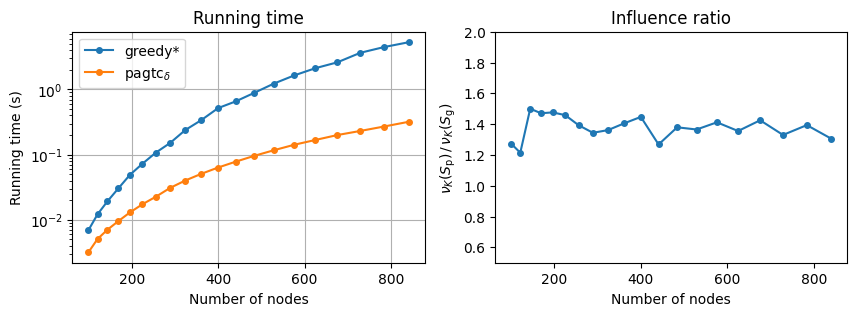

In [11]:
small_world = {}
for n in range(10,30):
    G = nx.navigable_small_world_graph(n, q=3, dim=2, seed=42)
    G.remove_edges_from(nx.selfloop_edges(G))
    G = G.to_undirected().to_directed()
    small_world[n] = G

strategies = {
    'greedy*': full_greedy_strategy,
    r'pagtc$_\delta$': None,
}

for strategy in strategies:
    score = {strategy: {} for strategy in strategies}
    running_time = {strategy: {} for strategy in strategies}

for n in small_world:
    G = small_world[n]
    n_nodes = len(G.nodes())

    K = 5
    r = int(len(G)/10)

    strategies[r'pagtc$_\delta$'] = pagtc_delta_strategy(r-1)

    for strategy in strategies:
        tic = time.time()
        score[strategy][n_nodes] = test_one_round_evolution(G, K, r, {strategy: strategies[strategy]}, opt=False, draw=False)[strategy]
        toc = time.time()
        running_time[strategy][n_nodes] = toc - tic

fig, ax = plt.subplots(1, 2, figsize=(10,3))

for strategy in strategies:
    ax[0].semilogy(running_time[strategy].keys(), running_time[strategy].values(), label=strategy, marker='o', markersize=4)

x = list(score['greedy*'].keys())
y = [score[r'pagtc$_\delta$'][k] / score['greedy*'][k] for k in x]
ax[1].plot(x, y, marker='o', markersize=4)

ax[0].set_xlabel('Number of nodes')
ax[0].set_ylabel('Running time (s)')
ax[0].set_title('Running time')
ax[0].legend()
ax[0].grid()
ax[1].set_xlabel('Number of nodes')
ax[1].set_ylabel(r'$\nu_K(S_{\mathrm{p}})\,/\,\nu_K(S_{\mathrm{g}})$')
ax[1].set_title('Influence ratio')
ax[1].set_ylim(0.5,2)
pass

### Code for Figure 4

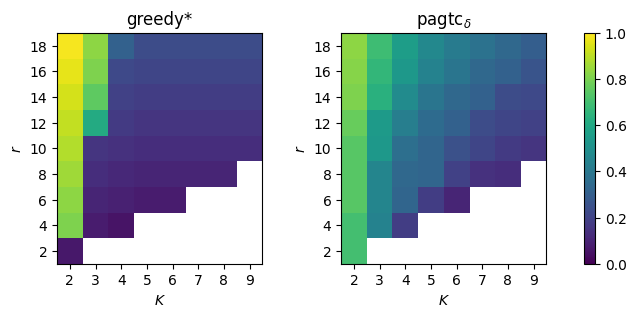

In [12]:
Ks = range(2,10)
rs = range(2,20,2)

strategies = {
    'greedy*': full_greedy_strategy,
    r'pagtc$_\delta$': None,
}

score = {}
for strategy in strategies:
    score[strategy] = np.zeros((len(rs), len(Ks)))

for strategy in strategies:
    for i, K in enumerate(Ks):
        for j, r in enumerate(rs):
            if r >= K:
                strategies[r'pagtc$_\delta$'] = pagtc_delta_strategy(r-1)
                score[strategy][j][i] = test_full_evolution(les_miserables, K, r, {strategy: strategies[strategy]}, opt=False, draw=False)[strategy]
            else:
                score[strategy][j][i] = np.nan

fig, ax = plt.subplots(1, 2, figsize=(8,3))

for i, strategy in enumerate(strategies):
    im = ax[i].imshow(score[strategy], cmap='viridis', origin='lower', vmin=0, vmax=1)
    ax[i].set_xticks(np.arange(len(Ks)))
    ax[i].set_yticks(np.arange(len(rs)))
    ax[i].set_xticklabels(Ks)
    ax[i].set_yticklabels(rs)
    ax[i].set_title(strategy)
    ax[i].set_xlabel('$K$')
    ax[i].set_ylabel('$r$')
fig.colorbar(im, ax=ax, fraction=0.1, pad=0.06)
pass

### Code for Figure 5

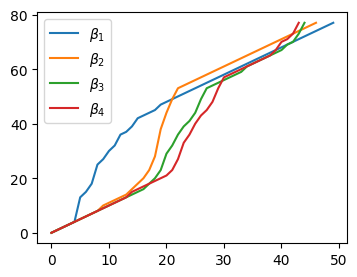

In [13]:
np.random.seed(1)
strategies = {
    r'$\beta_1$': pagtc_beta_strategy(0.25),
    r'$\beta_2$': pagtc_beta_strategy(0.50),
    r'$\beta_3$': pagtc_beta_strategy(0.75),
    r'$\beta_4$': pagtc_beta_strategy(1.00),
} 
score = test_targeted_evolution(les_miserables, 5, strategies, draw=True)